In [23]:
# Native libraries
import os
import math
# Essential Libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# Preprocessing
from sklearn.preprocessing import MinMaxScaler
# Algorithms
from statistics import mean, stdev, variance
from minisom import MiniSom
from tslearn.barycenters import dtw_barycenter_averaging
from tslearn.clustering import TimeSeriesKMeans
from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth
from collections import Counter
from sklearn.decomposition import PCA

In [2]:
csv = pd.read_csv("monthly_small_data.csv")

In [10]:
num = 0
for i in range(270, 271):
    num += list(csv.isna().sum()).count(i)


In [11]:
num

4074

In [ ]:
target = pd.read_csv("target.csv")

In [3]:
csv = csv.drop("date", axis=1)


def nan_counter(list_of_series):
    nan_polluted_series_counter = 0
    for series in list_of_series:
        series = list_of_series[series]
        if series.isnull().sum().sum() > 0:
            nan_polluted_series_counter += 1


csv.interpolate(limit_direction="both", inplace=True)
nan_counter(csv)
names = csv

In [10]:
names = csv
scaler = MinMaxScaler()
csv = MinMaxScaler().fit_transform(csv)
som_x = som_y = math.ceil(math.sqrt(math.sqrt(len(csv))))
csv = np.transpose(csv)

In [15]:
som_x = som_y = math.ceil(math.sqrt(math.sqrt(len(csv))))
# I didn't see its significance but to make the map square,
# I calculated square root of map size which is 
# the square root of the number of series
# for the row and column counts of som

som = MiniSom(som_x, som_y,len(csv[0]), sigma=0.3, learning_rate = 0.1)

som.random_weights_init(csv)
som.train(csv, 50000)

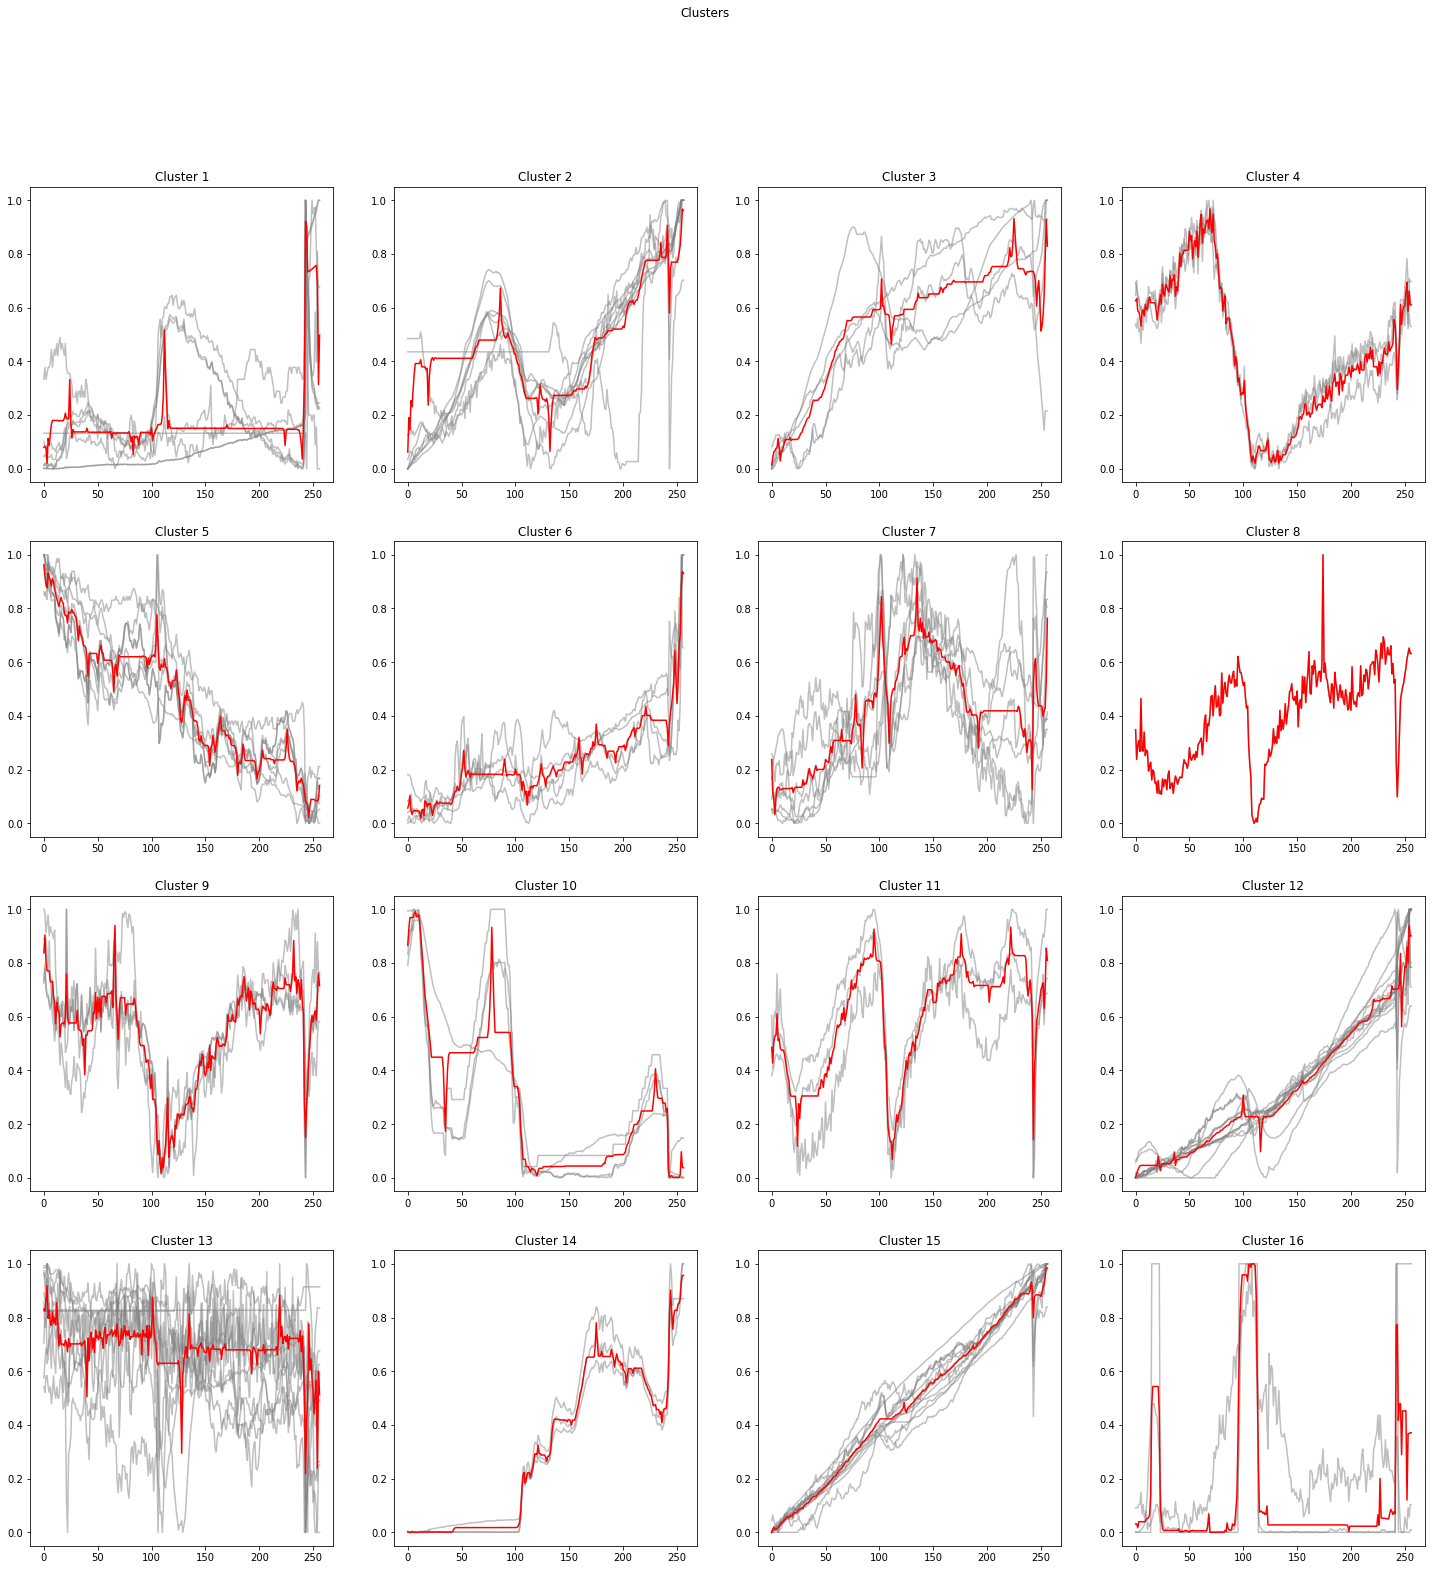

In [35]:

def plot_som_series_dba_center(som_x, som_y, win_map):
    fig, axs = plt.subplots(som_x, som_y, figsize=(25, 25))
    fig.suptitle('Clusters')
    for x in range(som_x):
        for y in range(som_y):
            cluster = (x, y)
            if cluster in win_map.keys():
                for series in win_map[cluster]:
                    axs[cluster].plot(series, c="gray", alpha=0.5)
                axs[cluster].plot(dtw_barycenter_averaging(np.vstack(win_map[cluster])), c="red")  # I changed this part
            cluster_number = x * som_y + y + 1
            axs[cluster].set_title(f"Cluster {cluster_number}")

    plt.show()

win_map = som.win_map(csv)
plot_som_series_dba_center(som_x, som_y, win_map)

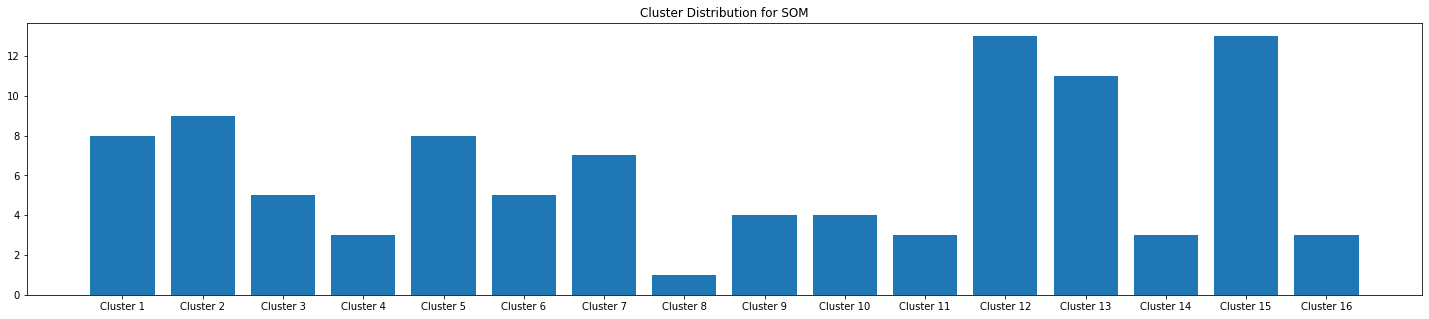

In [36]:
cluster_c = []
cluster_n = []
for x in range(som_x):
    for y in range(som_y):
        cluster = (x,y)
        if cluster in win_map.keys():
            cluster_c.append(len(win_map[cluster]))
        else:
            cluster_c.append(0)
        cluster_number = x*som_y+y+1
        cluster_n.append(f"Cluster {cluster_number}")

plt.figure(figsize=(25,5))
plt.title("Cluster Distribution for SOM")
plt.bar(cluster_n,cluster_c)
plt.show()

                  Name
Cluster               
Cluster 1       UNRATE
Cluster 1         M1NS
Cluster 1      ISRATIO
Cluster 1       U6RATE
Cluster 1     UNEMPLOY
...                ...
Cluster 8      DGORDER
Cluster 9  HTRUCKSSAAR
Cluster 9      TOTALSA
Cluster 9     ALTSALES
Cluster 9      UMCSENT

[100 rows x 1 columns]


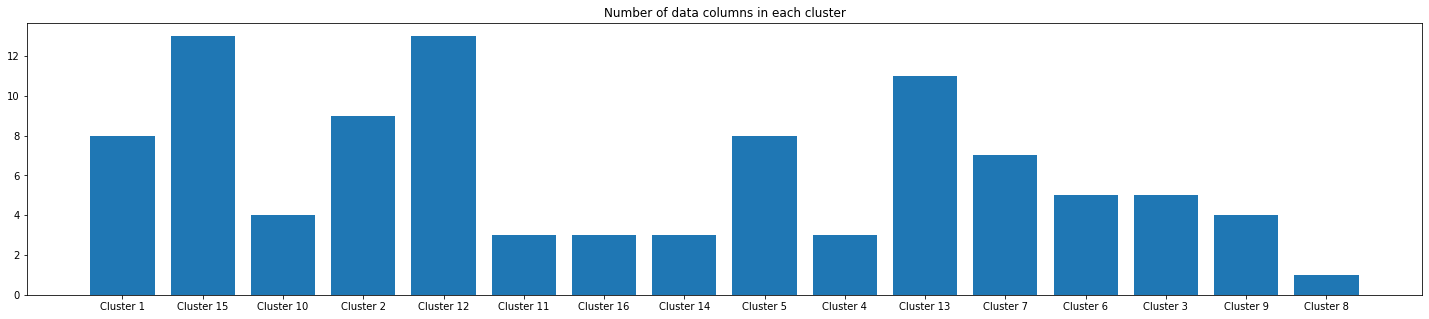

Standard Deviation of all data for Cluster 15: 88280.2957806925

Standard Deviation for means of columns for Cluster 15: 91749.96661965374


In [39]:
cluster_map = []
i = 0
cluster_x = []
cluster_dict = {}
for idx in names:
    winner_node = som.winner(csv[i])
    name = f"Cluster {winner_node[0] * som_y + winner_node[1] + 1}"
    cluster_map.append((idx, name))

    cluster_x.append(name)
    i += 1

cluster_x = Counter(cluster_x)
clusters = pd.DataFrame(cluster_map, columns=["Name", "Cluster"]).sort_values(by="Cluster").set_index("Cluster")
print(clusters)
plt.figure(figsize=(25, 5))
plt.title("Number of data columns in each cluster")
plt.bar(cluster_x.keys(), cluster_x.values())
plt.show()
datas = []
means = []
for name in clusters.loc[cluster_x.most_common()[0][0]]["Name"].values:
    data = names[name].values
    datas += list(data)
    means.append(mean(list(data)))
print(f"Standard Deviation of all data for {cluster_x.most_common()[0][0]}: {stdev(datas)}")
print(f"\nStandard Deviation for means of columns for {cluster_x.most_common()[0][0]}: {stdev(means)}")


In [11]:
cluster_count = math.ceil(math.sqrt(len(csv))) 
# A good rule of thumb is choosing k as the square root of the number of points in the training data set in kNN

km = TimeSeriesKMeans(n_clusters=cluster_count, metric="dtw")

labels = km.fit_predict(csv)

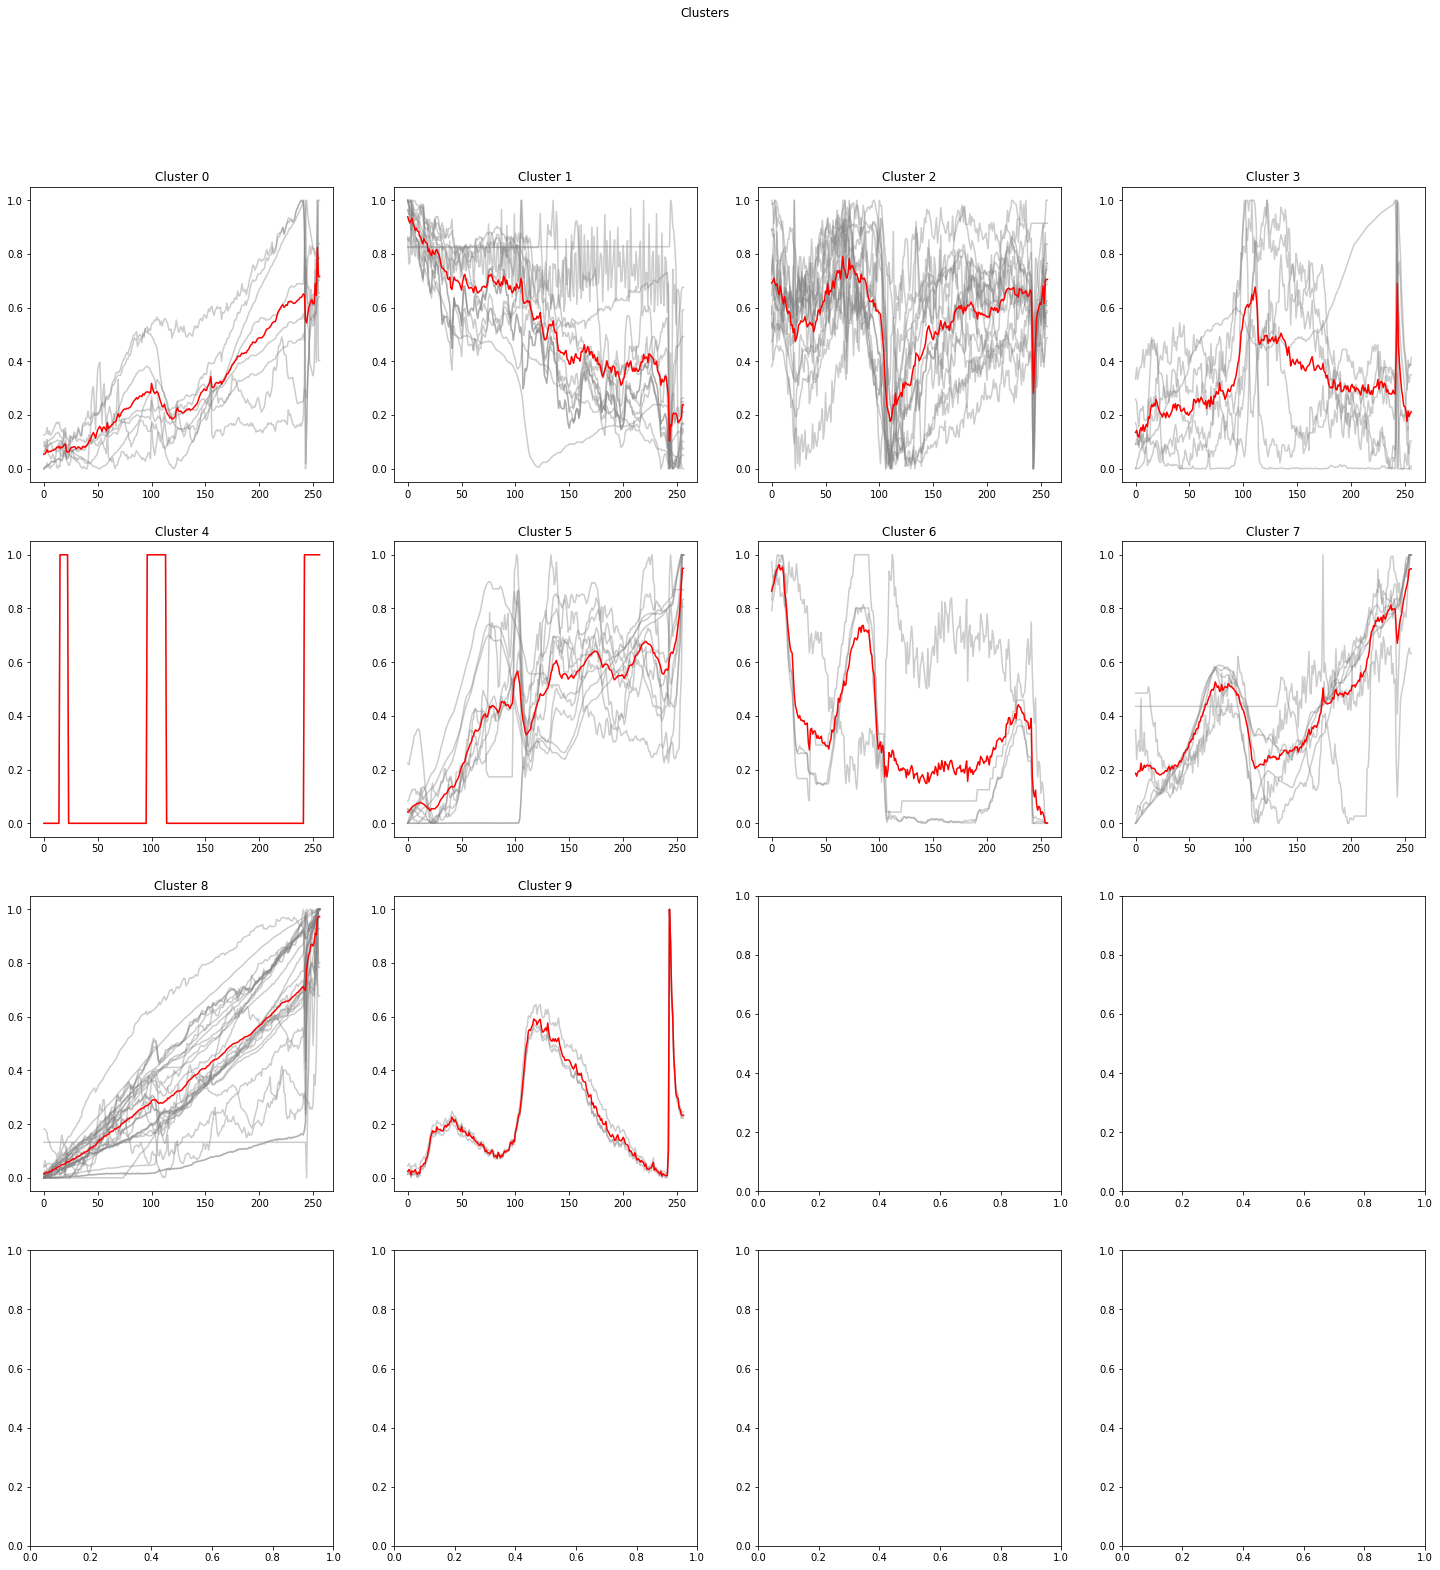

In [18]:
plot_count = math.ceil(math.sqrt(cluster_count))

fig, axs = plt.subplots(plot_count,plot_count,figsize=(25,25))
fig.suptitle('Clusters')
row_i=0
column_j=0
# For each label there is,
# plots every series with that label
for label in set(labels):
    cluster = []
    for i in range(len(labels)):
            if(labels[i]==label):
                axs[row_i, column_j].plot(csv[i],c="gray",alpha=0.4)
                cluster.append(csv[i])
    if len(cluster) > 0:
        axs[row_i, column_j].plot(np.average(np.vstack(cluster),axis=0),c="red")
    axs[row_i, column_j].set_title("Cluster "+str(row_i*som_y+column_j))
    column_j+=1
    if column_j%plot_count == 0:
        row_i+=1
        column_j=0
        
plt.show()

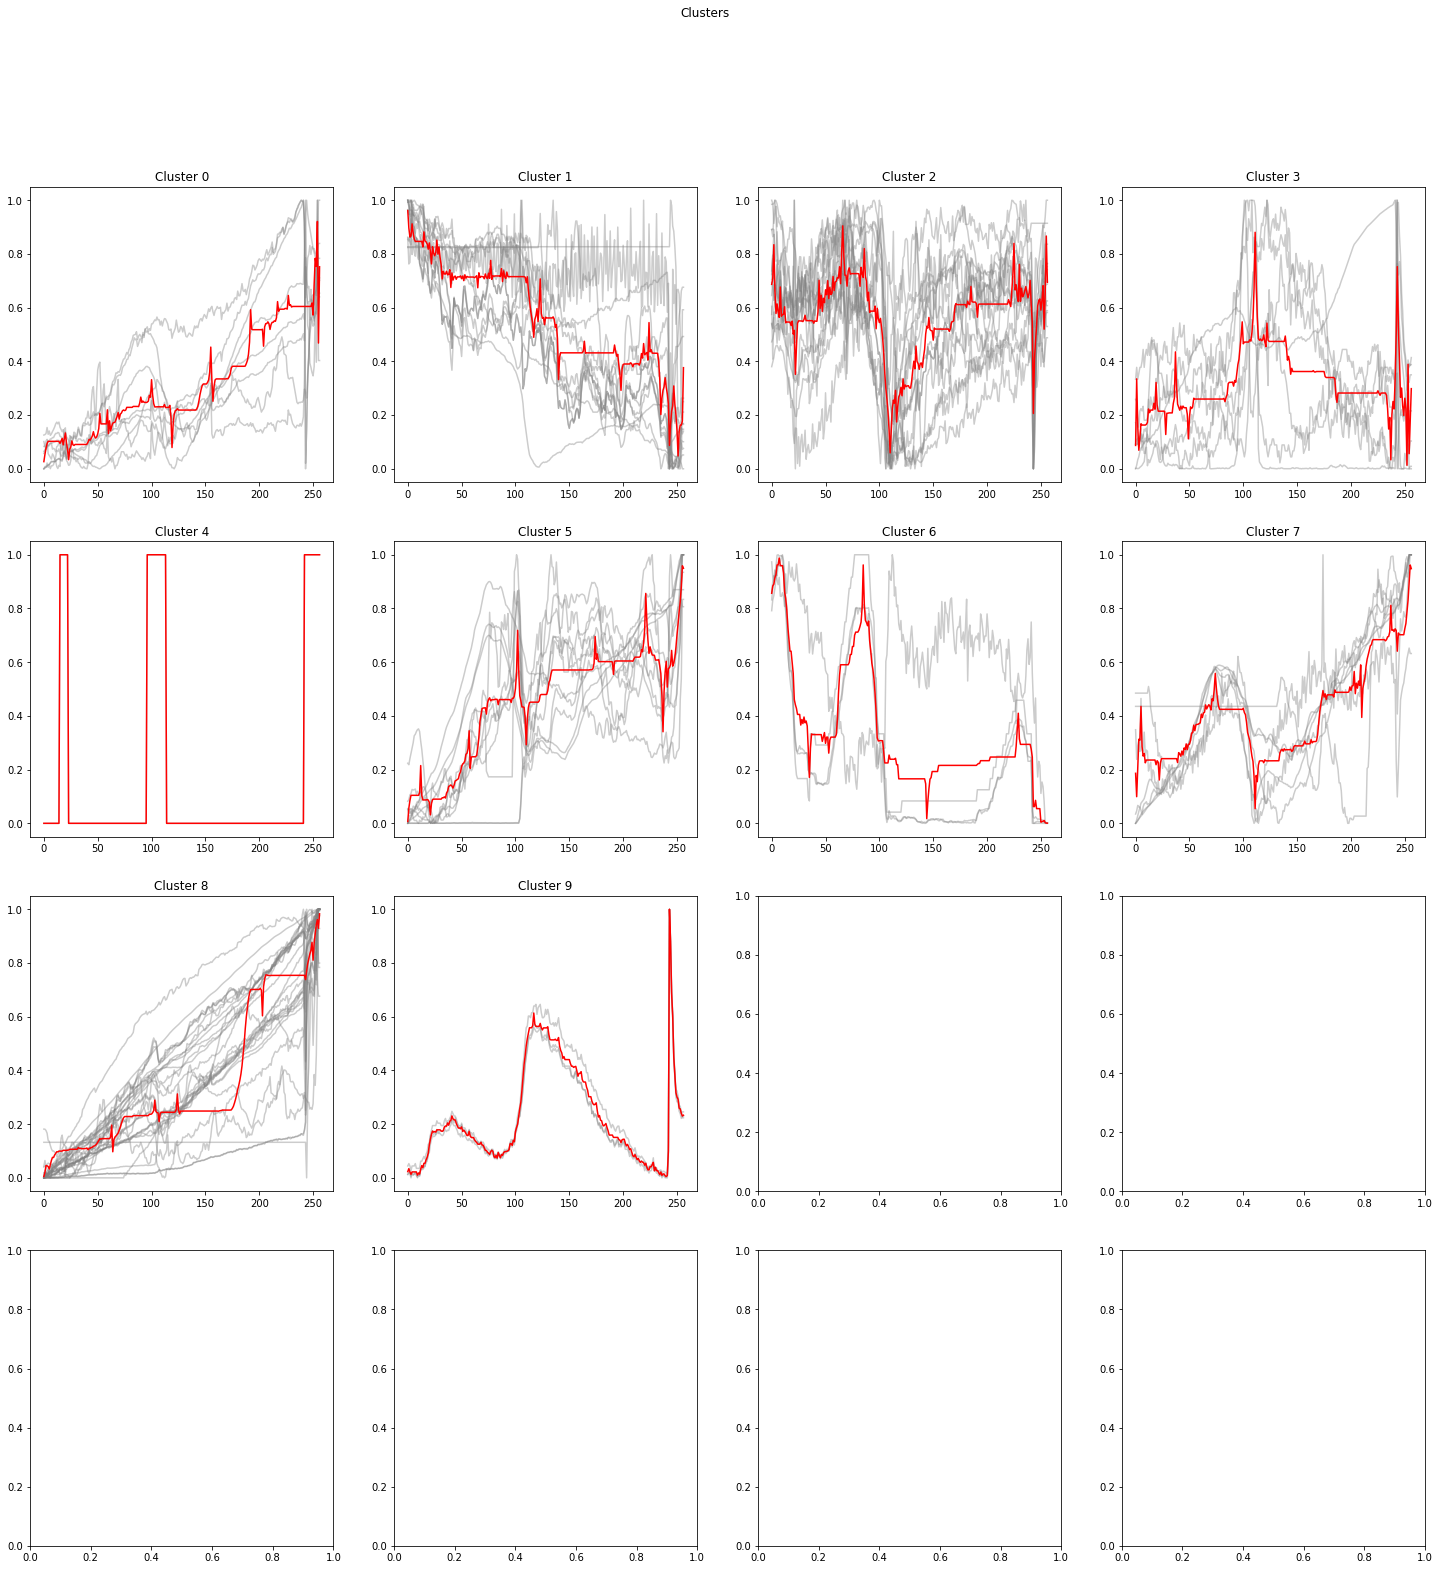

In [19]:
plot_count = math.ceil(math.sqrt(cluster_count))

fig, axs = plt.subplots(plot_count,plot_count,figsize=(25,25))
fig.suptitle('Clusters')
row_i=0
column_j=0
for label in set(labels):
    cluster = []
    for i in range(len(labels)):
            if(labels[i]==label):
                axs[row_i, column_j].plot(csv[i],c="gray",alpha=0.4)
                cluster.append(csv[i])
    if len(cluster) > 0:
        axs[row_i, column_j].plot(dtw_barycenter_averaging(np.vstack(cluster)),c="red")
    axs[row_i, column_j].set_title("Cluster "+str(row_i*som_y+column_j))
    column_j+=1
    if column_j%plot_count == 0:
        row_i+=1
        column_j=0
        
plt.show()

                  Name
Cluster               
Cluster 1       UNRATE
Cluster 1         M1NS
Cluster 1      ISRATIO
Cluster 1       U6RATE
Cluster 1     UNEMPLOY
...                ...
Cluster 8      DGORDER
Cluster 9  HTRUCKSSAAR
Cluster 9      TOTALSA
Cluster 9     ALTSALES
Cluster 9      UMCSENT

[100 rows x 1 columns]


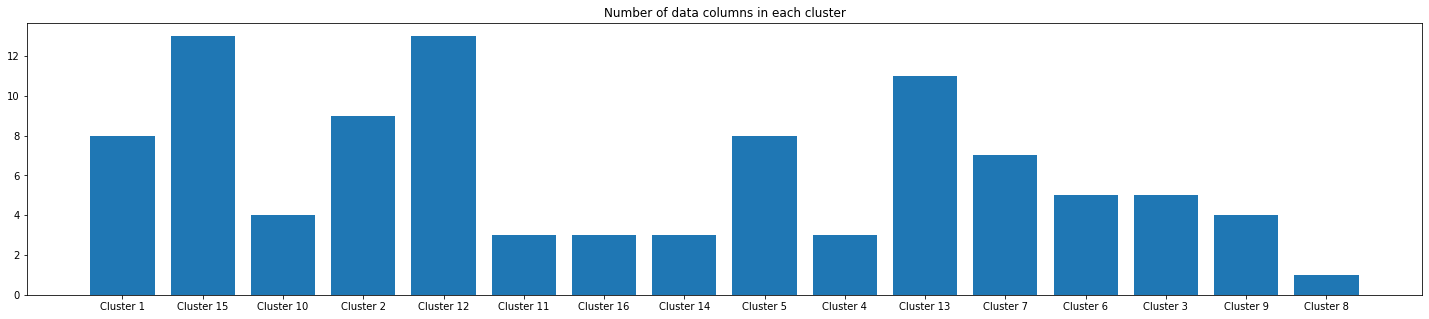

88280.2957806925
91749.96661965374


In [24]:

cluster_map = []
i = 0
cluster_x = []
cluster_dict = {}
for idx in names:
    winner_node = som.winner(csv[i])
    name = f"Cluster {winner_node[0] * som_y + winner_node[1] + 1}"
    cluster_map.append((idx, name))

    cluster_x.append(name)
    i += 1

cluster_x = Counter(cluster_x)
clusters = pd.DataFrame(cluster_map, columns=["Name", "Cluster"]).sort_values(by="Cluster").set_index("Cluster")
print(clusters)
plt.figure(figsize=(25, 5))
plt.title("Number of data columns in each cluster")
plt.bar(cluster_x.keys(), cluster_x.values())
plt.show()
datas = []
means = []
for name in clusters.loc[cluster_x.most_common()[0][0]]["Name"].values:
    data = names[name].values
    datas += list(data)
    means.append(mean(list(data)))
print(f"Standard Deviation of all data for {cluster_x.most_common()[0][0]}: {stdev(datas)}")
print(f"\nStandard Deviation for means of columns for {cluster_x.most_common()[0][0]}: {stdev(means)}")



In [25]:
pca = PCA(n_components=2)

mySeries_transformed = pca.fit_transform(csv)

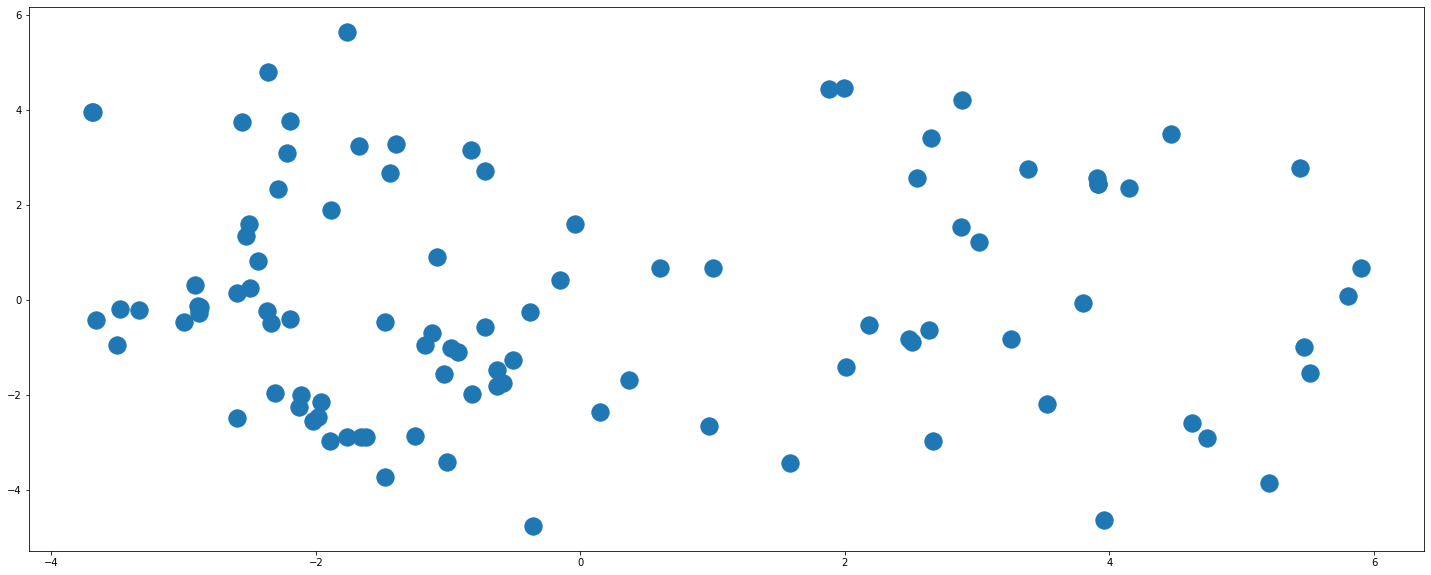

In [26]:
plt.figure(figsize=(25,10))
plt.scatter(mySeries_transformed[:,0],mySeries_transformed[:,1], s=300)
plt.show()

In [27]:
kmeans = KMeans(n_clusters=cluster_count,max_iter=5000)

labels = kmeans.fit_predict(mySeries_transformed)

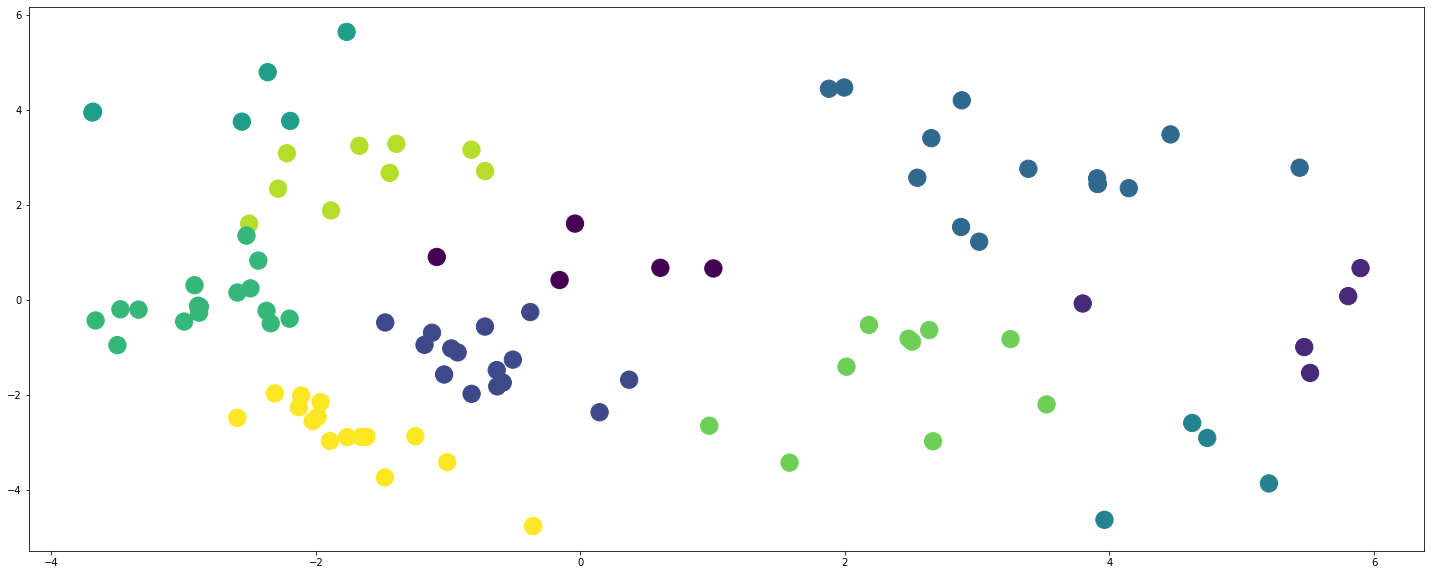

In [28]:
plt.figure(figsize=(25,10))
plt.scatter(mySeries_transformed[:, 0], mySeries_transformed[:, 1], c=labels, s=300)
plt.show()

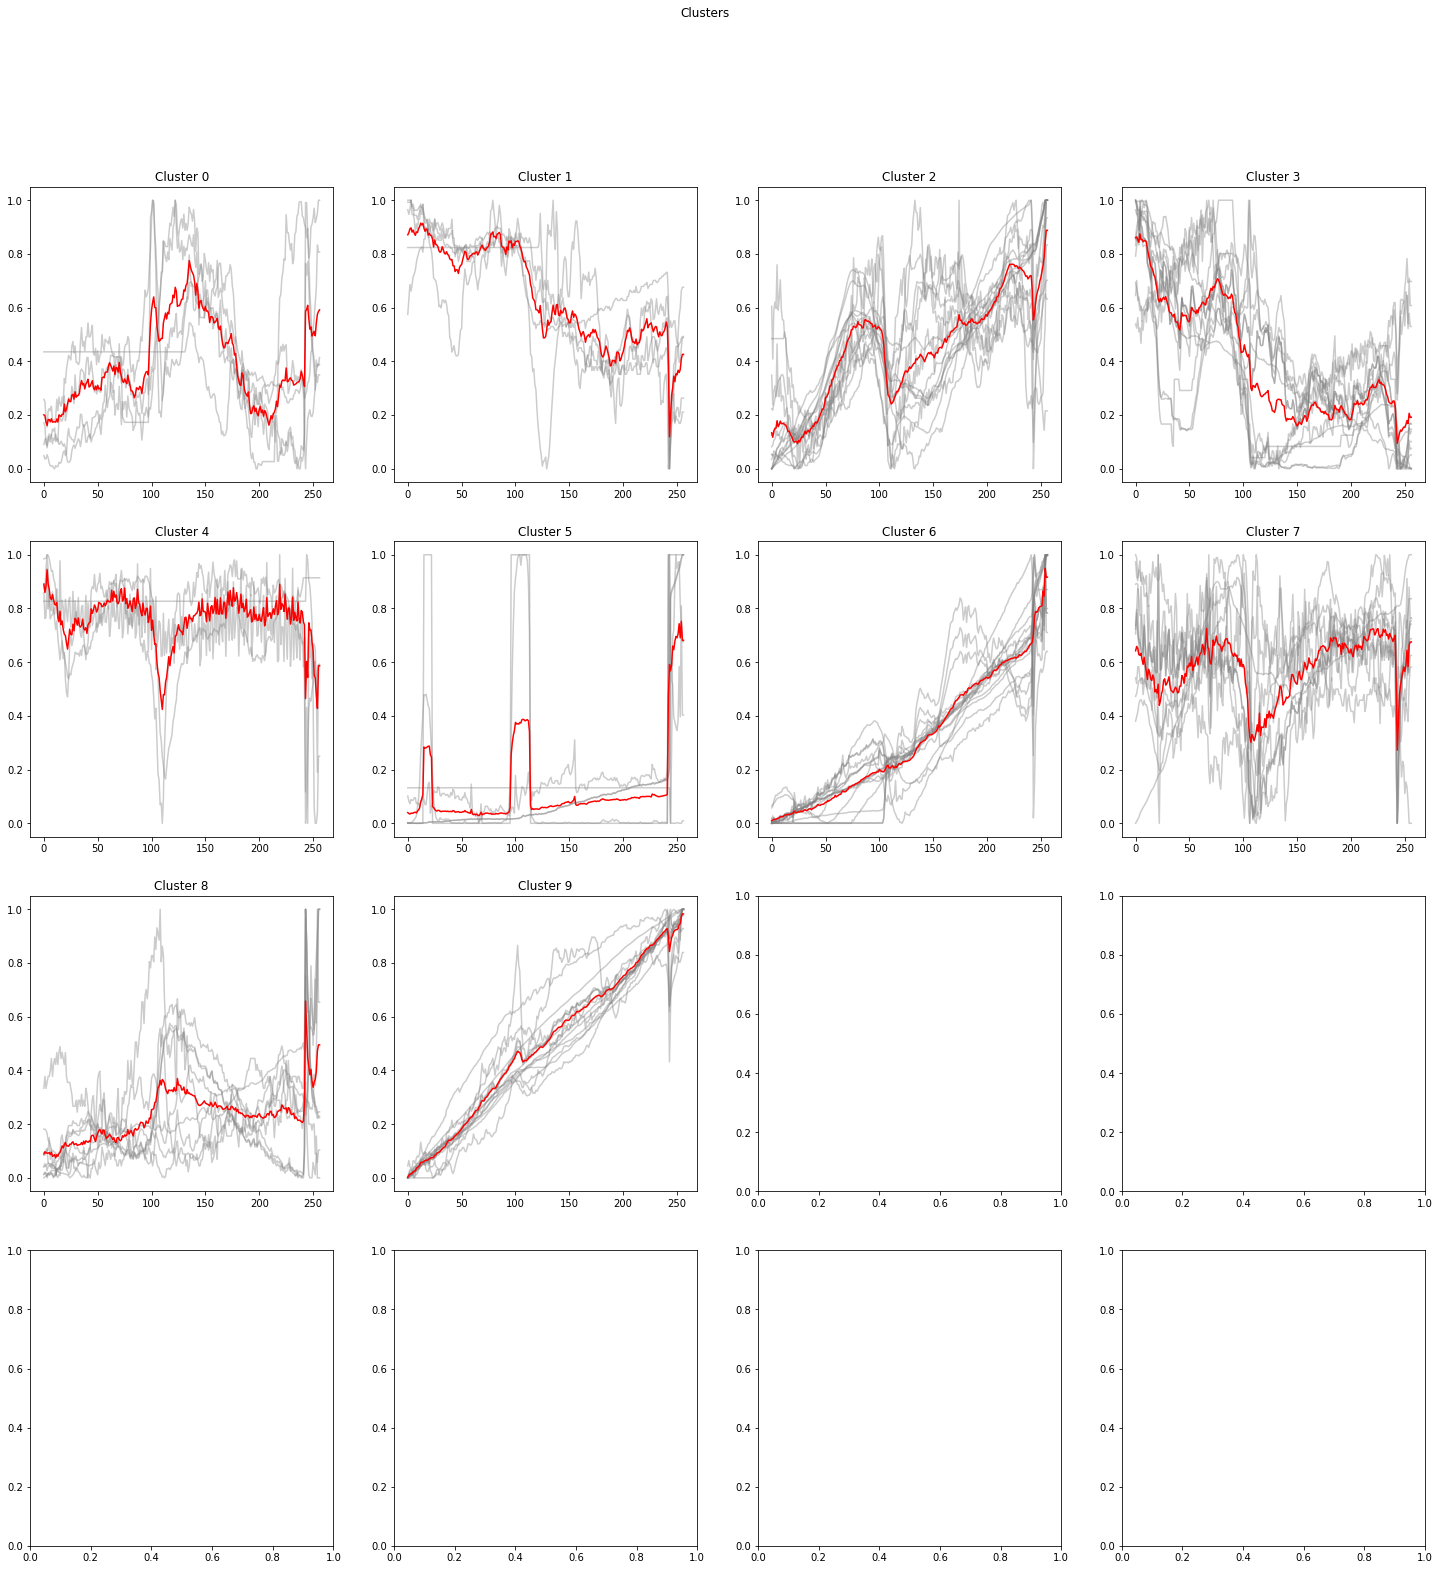

In [30]:
plot_count = math.ceil(math.sqrt(cluster_count))

fig, axs = plt.subplots(plot_count,plot_count,figsize=(25,25))
fig.suptitle('Clusters')
row_i=0
column_j=0
for label in set(labels):
    cluster = []
    for i in range(len(labels)):
            if(labels[i]==label):
                axs[row_i, column_j].plot(csv[i],c="gray",alpha=0.4)
                cluster.append(csv[i])
    if len(cluster) > 0:
        axs[row_i, column_j].plot(np.average(np.vstack(cluster),axis=0),c="red")
    axs[row_i, column_j].set_title("Cluster "+str(row_i*som_y+column_j))
    column_j+=1
    if column_j%plot_count == 0:
        row_i+=1
        column_j=0
        
plt.show()

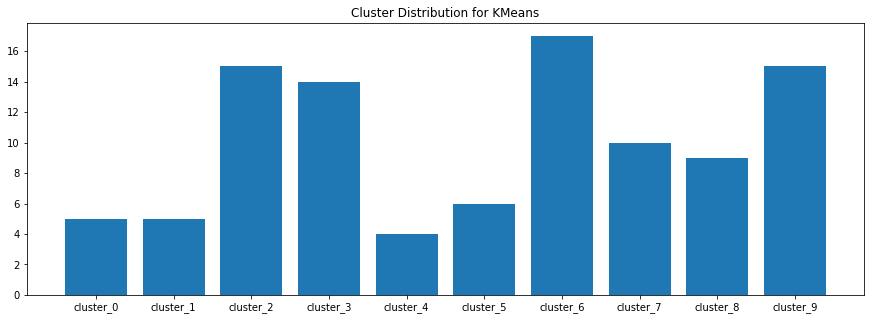

In [31]:
cluster_c = [len(labels[labels==i]) for i in range(cluster_count)]
cluster_n = ["cluster_"+str(i) for i in range(cluster_count)]
plt.figure(figsize=(15,5))
plt.title("Cluster Distribution for KMeans")
plt.bar(cluster_n,cluster_c)
plt.show()cluster_c = [len(labels[labels==i]) for i in range(cluster_count)]
cluster_n = ["cluster_"+str(i) for i in range(cluster_count)]
plt.figure(figsize=(15,5))
plt.title("Cluster Distribution for KMeans")
plt.bar(cluster_n,cluster_c)
plt.show()

                  Name
Cluster               
Cluster 1       UNRATE
Cluster 1         M1NS
Cluster 1      ISRATIO
Cluster 1       U6RATE
Cluster 1     UNEMPLOY
...                ...
Cluster 8      DGORDER
Cluster 9  HTRUCKSSAAR
Cluster 9      TOTALSA
Cluster 9     ALTSALES
Cluster 9      UMCSENT

[100 rows x 1 columns]


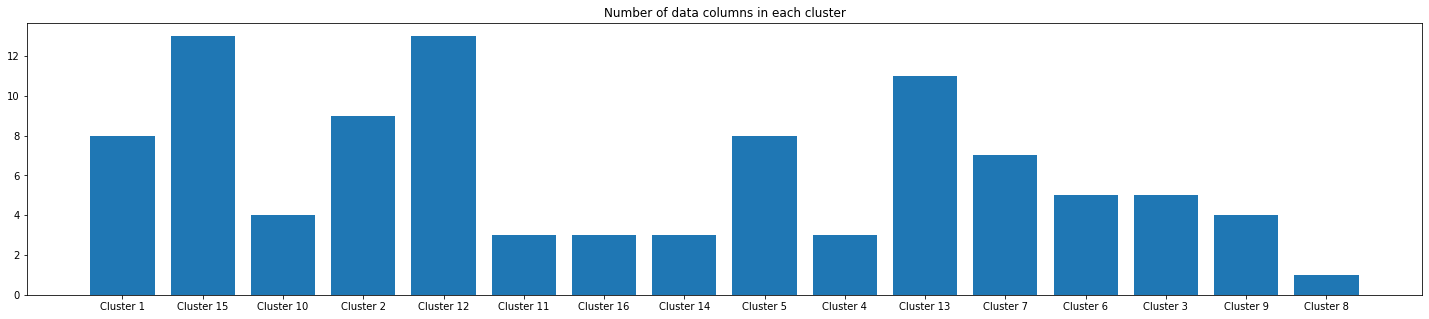

Standard Deviation of all data: 88280.2957806925

Standard Deviation for means of columns: 91749.96661965374


In [33]:
cluster_map = []
i = 0
cluster_x = []
cluster_dict = {}
for idx in names:
    winner_node = som.winner(csv[i])
    name = f"Cluster {winner_node[0] * som_y + winner_node[1] + 1}"
    cluster_map.append((idx, name))

    cluster_x.append(name)
    i += 1

cluster_x = Counter(cluster_x)
clusters = pd.DataFrame(cluster_map, columns=["Name", "Cluster"]).sort_values(by="Cluster").set_index("Cluster")
print(clusters)
plt.figure(figsize=(25, 5))
plt.title("Number of data columns in each cluster")
plt.bar(cluster_x.keys(), cluster_x.values())
plt.show()
datas = []
means = []
for name in clusters.loc[cluster_x.most_common()[0][0]]["Name"].values:
    data = names[name].values
    datas += list(data)
    means.append(mean(list(data)))
print(f"Standard Deviation of all data for {cluster_x.most_common()[0][0]}: {stdev(datas)}")
print(f"\nStandard Deviation for means of columns for {cluster_x.most_common()[0][0]}: {stdev(means)}")
